In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [ ]:
# Descargando el dataset de Kaggle
od.download('https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?select=Data')

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from matplotlib import pyplot as plt
import io
import random

import cv2 as cv

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  GaussianNB
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
def wave_augmentation(audio, samp_r, tipo):
  rango_tonos = [-2,2] # Rango para los cambios de tono
  rango_velocidad = [0.4, 1.2] # Rango de cambios de velocidad
  ruido = 0.1 # Variación de ruido

  if tipo == 'tono':
    # Selección aleatoria de cambio de tono
    tono_selec = random.uniform(rango_tonos[0], rango_tonos[1])
    # Aplicar cambio
    newWave = librosa.effects.pitch_shift(y = audio, sr = samp_r, n_steps=tono_selec)
  elif tipo == 'vel':
    # Seleccion de vel
    vel_selec = random.uniform(rango_velocidad[0], rango_velocidad[1])
    # Aplicar
    newWave = librosa.effects.time_stretch(y = audio, rate = vel_selec)
  elif tipo == 'gauss':
    # Ruido gauss
    newWave = audio + np.random.normal(0, ruido, size=len(audio))

  return newWave

In [5]:
clases = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [6]:
D = {}
for carpeta in os.listdir('gtzan-dataset-music-genre-classification/Data/genres_original/'):
    if carpeta in clases:
        D[carpeta] = []
        for nombreM in os.listdir('gtzan-dataset-music-genre-classification/Data/genres_original/' + carpeta):
          try:
            wave, sam_r = librosa.load('gtzan-dataset-music-genre-classification/Data/genres_original/'+carpeta+'/'+nombreM,sr=22050)
            D[carpeta].append(wave)
            ## Se generarán los 3 tipos de augmentation para cada audio
            #t = random.choice(['tono', 'vel', 'gauss'])
            #generated = wave_augmentation(wave, sam_r, t)
            #D[carpeta].append(generated)
          except:
            print('Error con archivo', nombreM, 'Omitiéndolo...')

Error con archivo jazz.00054.wav Omitiéndolo...


In [7]:
for k in D:
  print(k, len(D[k]))

country 100
classical 100
blues 100
rock 100
metal 100
disco 100
pop 100
reggae 100
hiphop 100
jazz 99


In [8]:
def get_mel_spectogram2(onda):
    mewSpectogram = librosa.feature.melspectrogram(y=onda, sr=sam_r , hop_length=512)
    mel_spectrogram_log = librosa.power_to_db(mewSpectogram, ref=np.max)
    mel_spectrogram_log = mel_spectrogram_log.astype(np.uint8)
    spec_img = cv.applyColorMap(mel_spectrogram_log, cv.COLORMAP_JET)
    spec_img = cv.cvtColor(spec_img, cv.COLOR_BGR2RGB)
    return spec_img

In [9]:
i1= get_mel_spectogram2(D['classical'][0])

In [10]:
i1.shape

(128, 1293, 3)

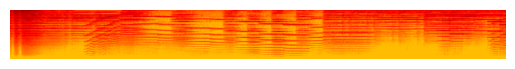

In [11]:
plt.imshow(i1)
plt.axis('off')
plt.show()

In [12]:
D_imgs = {}
for clase in clases:
    D_imgs[clase] = []
    print('Extrayendo de', clase ,end='')
    for i in range(len(D[clase])):
        audio = D[clase][i]
        try:
            img = get_mel_spectogram2(audio)
            if img.shape != (128,1293,3):
                img.reshape((128,1293,3))
            D_imgs[clase].append(img)
            print('.', end='')
        except:
            print('x', end='')
    print('\n¡Finalizado!')

Extrayendo de blues....................................................................................................
¡Finalizado!
Extrayendo de classical..................x......x....................x.....................x..x.......x......x..........x..
¡Finalizado!
Extrayendo de country....................x..................x.........x......x....................x..x....x.........xx...
¡Finalizado!
Extrayendo de disco..x...................x.............x....x....x..............................xx........x............
¡Finalizado!
Extrayendo de hiphop....x.............x......x.............xx..x.....xx..x...x...x.x........x.....xxx........x.......x..
¡Finalizado!
Extrayendo de jazz.................x...................x..............x........x........x.............x...........x..
¡Finalizado!
Extrayendo de metal....................................................................................................
¡Finalizado!
Extrayendo de pop...............................................

In [13]:
for k in D_imgs:
  print(k, len(D_imgs[k]))

blues 100
classical 92
country 91
disco 92
hiphop 82
jazz 92
metal 100
pop 100
reggae 100
rock 95


In [14]:
ls_clase_imgs = np.concatenate([np.zeros(100), np.ones(92), np.full(91,2), np.full(92,3), np.full(82,4), np.full(92,5), np.full(100,6),np.full(100,7),np.full(100,8),np.full(95,9)], axis=0)
ls_audio_imgs = np.concatenate([D_imgs['blues'], D_imgs['classical'], D_imgs['country'], D_imgs['disco'], D_imgs['hiphop'], D_imgs['jazz'],D_imgs['metal'], D_imgs['pop'],D_imgs['reggae'],D_imgs['rock']], axis=0 )

In [15]:
X = ls_audio_imgs
y = ls_clase_imgs

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Modelos CNN

In [17]:
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential

In [18]:
numero_class = 10

In [19]:
ancho_img, alto_img, _ = get_mel_spectogram2(D['classical'][0]).shape
ancho_img, alto_img

(128, 1293)

#### Transer learning con Inception

In [ ]:
from keras.applications import InceptionV3


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False     

In [ ]:
model = Sequential(name = 'InceptionCorcino')

model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')

In [ ]:
model.fit(X_train, y_train, epochs=35, batch_size=32)

Epoch 1/35
24/24 [==============================] - 11s 184ms/step - loss: 419.5200 - accuracy: 0.1232
Epoch 2/35
24/24 [==============================] - 4s 187ms/step - loss: 82.7665 - accuracy: 0.2238
Epoch 3/35
24/24 [==============================] - 4s 187ms/step - loss: 45.9029 - accuracy: 0.2464
Epoch 4/35
24/24 [==============================] - 5s 189ms/step - loss: 20.7652 - accuracy: 0.3709
Epoch 5/35
24/24 [==============================] - 5s 191ms/step - loss: 10.6441 - accuracy: 0.4649
Epoch 6/35
24/24 [==============================] - 5s 191ms/step - loss: 7.2104 - accuracy: 0.5444
Epoch 7/35
24/24 [==============================] - 5s 192ms/step - loss: 7.1779 - accuracy: 0.5298
Epoch 8/35
24/24 [==============================] - 5s 190ms/step - loss: 4.8137 - accuracy: 0.5987
Epoch 9/35
24/24 [==============================] - 5s 189ms/step - loss: 3.0433 - accuracy: 0.6848
Epoch 10/35
24/24 [==============================] - 5s 191ms/step - loss: 2.6502 - accuracy:

In [ ]:
model.evaluate(X_test,y_test)

6/6 [==============================] - 2s 179ms/step - loss: 5.9370 - accuracy: 0.6190


[5.937010288238525, 0.6190476417541504]

In [ ]:
#LISTO

# VGG19

In [ ]:
from keras.applications import VGG19

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model2 = Sequential(name = 'VGG19Corcino')

model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [ ]:
model2.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')

In [ ]:
model2.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
24/24 [==============================] - 15s 527ms/step - loss: 23.0911 - accuracy: 0.2384
Epoch 2/10
24/24 [==============================] - 13s 549ms/step - loss: 4.8385 - accuracy: 0.5603
Epoch 3/10
24/24 [==============================] - 13s 556ms/step - loss: 1.7987 - accuracy: 0.7523
Epoch 4/10
24/24 [==============================] - 13s 535ms/step - loss: 0.6207 - accuracy: 0.8808
Epoch 5/10
24/24 [==============================] - 13s 522ms/step - loss: 0.1373 - accuracy: 0.9669
Epoch 6/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0761 - accuracy: 0.9788
Epoch 7/10
24/24 [==============================] - 13s 523ms/step - loss: 0.0600 - accuracy: 0.9868
Epoch 8/10
24/24 [==============================] - 13s 534ms/step - loss: 0.0272 - accuracy: 0.9894
Epoch 9/10
24/24 [==============================] - 13s 539ms/step - loss: 0.0227 - accuracy: 0.9947
Epoch 10/10
24/24 [==============================] - 13s 536ms/step - loss: 0.0079 - accur

In [ ]:
model2.evaluate(X_test,y_test)

6/6 [==============================] - 3s 502ms/step - loss: 2.0094 - accuracy: 0.7407


[2.009434700012207, 0.7407407164573669]

In [ ]:
# LISTO

# VGG16

In [ ]:
from keras.applications import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model3 = Sequential(name = 'VGG16Corcino')

model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(10, activation='softmax'))

In [ ]:
model3.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')

In [ ]:
model3.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
24/24 [==============================] - 14s 423ms/step - loss: 32.1577 - accuracy: 0.2000
Epoch 2/15
24/24 [==============================] - 10s 418ms/step - loss: 4.6036 - accuracy: 0.5483
Epoch 3/15
24/24 [==============================] - 10s 416ms/step - loss: 1.2986 - accuracy: 0.7854
Epoch 4/15
24/24 [==============================] - 10s 418ms/step - loss: 0.2885 - accuracy: 0.9139
Epoch 5/15
24/24 [==============================] - 10s 421ms/step - loss: 0.1927 - accuracy: 0.9523
Epoch 6/15
24/24 [==============================] - 10s 425ms/step - loss: 0.0778 - accuracy: 0.9722
Epoch 7/15
24/24 [==============================] - 10s 428ms/step - loss: 0.0671 - accuracy: 0.9815
Epoch 8/15
24/24 [==============================] - 10s 429ms/step - loss: 0.0298 - accuracy: 0.9921
Epoch 9/15
24/24 [==============================] - 10s 428ms/step - loss: 0.0162 - accuracy: 0.9974
Epoch 10/15
24/24 [==============================] - 10s 427ms/step - loss: 0.0143 - accur

In [ ]:
model3.evaluate(X_test,y_test)

6/6 [==============================] - 3s 396ms/step - loss: 1.5503 - accuracy: 0.7884


[1.5503407716751099, 0.7883597612380981]

In [ ]:
# LISTO

# RESNET50

In [ ]:
from keras.applications import ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model4 = Sequential(name = 'Resnet50Corcino')

model4.add(base_model)
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(10, activation='softmax'))

In [ ]:
model4.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')

In [ ]:
model4.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
24/24 [==============================] - 11s 281ms/step - loss: 31.2091 - accuracy: 0.1695
Epoch 2/15
24/24 [==============================] - 7s 280ms/step - loss: 4.1562 - accuracy: 0.4795
Epoch 3/15
24/24 [==============================] - 7s 282ms/step - loss: 1.0880 - accuracy: 0.7417
Epoch 4/15
24/24 [==============================] - 7s 283ms/step - loss: 0.4634 - accuracy: 0.8623
Epoch 5/15
24/24 [==============================] - 7s 284ms/step - loss: 0.3189 - accuracy: 0.9126
Epoch 6/15
24/24 [==============================] - 7s 285ms/step - loss: 0.1447 - accuracy: 0.9483
Epoch 7/15
24/24 [==============================] - 7s 285ms/step - loss: 0.0422 - accuracy: 0.9841
Epoch 8/15
24/24 [==============================] - 7s 288ms/step - loss: 0.0233 - accuracy: 0.9947
Epoch 9/15
24/24 [==============================] - 7s 289ms/step - loss: 0.0133 - accuracy: 0.9987
Epoch 10/15
24/24 [==============================] - 7s 288ms/step - loss: 0.0157 - accuracy: 0.99

In [ ]:
model4.evaluate(X_test,y_test)

6/6 [==============================] - 3s 278ms/step - loss: 0.9243 - accuracy: 0.8042


[0.9243288636207581, 0.8042327761650085]

In [ ]:
# LISTO

In [ ]:
model4.save('ResCorcinoNetV100.h5')

# Resnet 101



In [ ]:
from keras.applications import ResNet101

In [ ]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model5 = Sequential(name = 'Resnet101Corcino')

model5.add(base_model)
model5.add(Flatten())
model5.add(Dense(256, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(10, activation='softmax'))

In [ ]:
model5.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')

In [ ]:
model5.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
24/24 [==============================] - 20s 475ms/step - loss: 28.9318 - accuracy: 0.2053
Epoch 2/20
24/24 [==============================] - 12s 485ms/step - loss: 5.0071 - accuracy: 0.5338
Epoch 3/20
24/24 [==============================] - 12s 495ms/step - loss: 2.0116 - accuracy: 0.6728
Epoch 4/20
24/24 [==============================] - 12s 491ms/step - loss: 1.2667 - accuracy: 0.7762
Epoch 5/20
24/24 [==============================] - 12s 486ms/step - loss: 0.4650 - accuracy: 0.8901
Epoch 6/20
24/24 [==============================] - 11s 479ms/step - loss: 0.2318 - accuracy: 0.9311
Epoch 7/20
24/24 [==============================] - 11s 478ms/step - loss: 0.0744 - accuracy: 0.9762
Epoch 8/20
24/24 [==============================] - 12s 479ms/step - loss: 0.0372 - accuracy: 0.9841
Epoch 9/20
24/24 [==============================] - 11s 478ms/step - loss: 0.0792 - accuracy: 0.9828
Epoch 10/20
24/24 [==============================] - 12s 485ms/step - loss: 0.0470 - accur

In [ ]:
model5.evaluate(X_test,y_test)

6/6 [==============================] - 5s 467ms/step - loss: 1.3463 - accuracy: 0.7725


[1.3462845087051392, 0.7724867463111877]

In [ ]:
# LISTO

# ResNet152

In [ ]:
from keras.applications import ResNet152

In [ ]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model6 = Sequential(name = 'Resnet152Corcino')

model6.add(base_model)
model6.add(Flatten())
model6.add(Dense(256, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(10, activation='softmax'))

In [ ]:
model6.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')

In [ ]:
model6.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
24/24 [==============================] - 27s 682ms/step - loss: 15.0948 - accuracy: 0.2212
Epoch 2/10
24/24 [==============================] - 17s 703ms/step - loss: 2.2570 - accuracy: 0.6252
Epoch 3/10
24/24 [==============================] - 17s 692ms/step - loss: 1.0834 - accuracy: 0.7695
Epoch 4/10
24/24 [==============================] - 16s 682ms/step - loss: 0.3723 - accuracy: 0.9033
Epoch 5/10
24/24 [==============================] - 16s 678ms/step - loss: 0.0741 - accuracy: 0.9775
Epoch 6/10
24/24 [==============================] - 16s 679ms/step - loss: 0.0711 - accuracy: 0.9788
Epoch 7/10
24/24 [==============================] - 16s 686ms/step - loss: 0.0224 - accuracy: 0.9894
Epoch 8/10
24/24 [==============================] - 16s 686ms/step - loss: 0.0154 - accuracy: 0.9974
Epoch 9/10
24/24 [==============================] - 16s 684ms/step - loss: 0.0208 - accuracy: 0.9987
Epoch 10/10
24/24 [==============================] - 16s 684ms/step - loss: 0.0334 - accur

In [ ]:
model6.evaluate(X_test,y_test)

6/6 [==============================] - 7s 659ms/step - loss: 1.3280 - accuracy: 0.7619


[1.3280367851257324, 0.761904776096344]

In [ ]:
# LISTO

# Modelo propio desde cero

In [54]:
from keras.models import Sequential

In [55]:
model7 = Sequential(name = 'CorcinoBasicNet')

model7.add(Conv2D(20, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(ancho_img, alto_img, 3)))

model7.add(Conv2D(20, kernel_size=(3,3), strides=(1,1), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model7.add(Conv2D(20, kernel_size=(3,3), strides=(1,1), activation='relu'))
model7.add(Conv2D(20, kernel_size=(3,3), strides=(1,1), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model7.add(Flatten())

model7.add(Dense(256, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(10, activation='softmax'))

In [56]:
model7.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')

In [57]:
model7.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
24/24 [==============================] - 8s 156ms/step - loss: 103.7645 - accuracy: 0.1139
Epoch 2/15
24/24 [==============================] - 4s 152ms/step - loss: 2.1860 - accuracy: 0.2238
Epoch 3/15
24/24 [==============================] - 4s 155ms/step - loss: 1.6699 - accuracy: 0.4609
Epoch 4/15
24/24 [==============================] - 4s 155ms/step - loss: 1.1574 - accuracy: 0.6238
Epoch 5/15
24/24 [==============================] - 4s 155ms/step - loss: 0.7656 - accuracy: 0.7788
Epoch 6/15
24/24 [==============================] - 4s 155ms/step - loss: 0.3175 - accuracy: 0.9285
Epoch 7/15
24/24 [==============================] - 4s 157ms/step - loss: 0.1310 - accuracy: 0.9748
Epoch 8/15
24/24 [==============================] - 4s 155ms/step - loss: 0.0384 - accuracy: 0.9934
Epoch 9/15
24/24 [==============================] - 4s 155ms/step - loss: 0.0278 - accuracy: 0.9947
Epoch 10/15
24/24 [==============================] - 4s 159ms/step - loss: 0.0304 - accuracy: 0.99

In [58]:
model7.evaluate(X_test,y_test)

6/6 [==============================] - 0s 48ms/step - loss: 1.6843 - accuracy: 0.5608


[1.6842827796936035, 0.5608465671539307]

In [ ]:
# LISTO

# TABLA FINAL

In [10]:
dicc_result_fin = {'Modelos':['knn + SURF', 'svm + SURF', 'lr + SURF', 'nb + SURF','knn + SURF 128', 'svm + SURF 128', 'lr + SURF 128', 'nb + SURF 128', 'knn + SIFT', 'svm + SIFT', 'lr + SIFT', 'nb + SIFT','knn + MFCC', 'svm + MFCC', 'lr + MFCC', 'nb + MFCC' , 'MLP + SURF', 'MLP + SURF 128', 'MLP + SIFT', 'MLP + MFCC', 'TL Inception' , 'TL VGG19', 'TL VGG16', 'TL ResNet50', 'TL ResNet101', 'TL ResNet152', 'CNN VP'], 'Accuracy':[0.5226, 0.5728, 0.5477, 0.4472, 0.5477, 0.6180, 0.5728, 0.4673, 0.5700, 0.6500, 0.6800, 0.4400, 0.6050, 0.6800, 0.6100, 0.4900, 0.6130, 0.5628, 0.6700, 0.5900, 0.6190, 0.7407, 0.7883, 0.8042, 0.7724, 0.7619, 0.5608]}

In [11]:
final = pd.DataFrame(dicc_result_fin)

In [12]:
final

,Modelos,Accuracy
0,knn + SURF,0.5226
1,svm + SURF,0.5728
2,lr + SURF,0.5477
3,nb + SURF,0.4472
4,knn + SURF 128,0.5477
5,svm + SURF 128,0.6180
6,lr + SURF 128,0.5728
7,nb + SURF 128,0.4673
8,knn + SIFT,0.5700
9,svm + SIFT,0.6500
